In [13]:
from torchvision.transforms import ToTensor
import rasterio
from rasterio.plot import show
import numpy as np
import geopandas as gp
from matplotlib.pyplot import plot
import rasterio.mask
import cv2
import matplotlib.pyplot as plt
import utils
import shapely

lakes_train_test = "/data1/malto/sigspatial/lakes_regions.gpkg"
lakes_regions_path = "/data1/malto/sigspatial/lake_polygons_training.gpkg"
regions = gp.read_file(lakes_train_test)
lakes_regions = gp.read_file(lakes_regions_path)


In [22]:
big_img_path = "/data1/malto/sigspatial/big_predictions/1/Greenland26X_22W_Sentinel2_2019-06-03_05.tif"
src = rasterio.open(big_img_path)
# x = src.bounds[0]
# y = src.bounds[3]
transformer = rasterio.transform.AffineTransformer(src.transform)
# transformer.xy(0, 0)
print(src.meta)


{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 13078, 'height': 8733, 'count': 3, 'crs': CRS.from_epsg(3857), 'transform': Affine(38.21851414258808, 0.0, -5581355.368355258,
       0.0, -38.21851414258808, 10875536.82144313)}


In [21]:
mask_array = src.read()
grayscale_image = cv2.cvtColor(mask_array.transpose(1, 2, 0), cv2.COLOR_BGR2GRAY)
contours, _ = cv2.findContours(grayscale_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(contours[0].reshape(-1,2)[0][0])
polygons = []
for c in contours:
    c = c.reshape(-1,2)
    new_poly = []
    for point in c:
        x = point[0]
        y = point[1]
        new_poly.append(transformer.xy(x, y))
    if len(new_poly) > 2:
        polygons.append(shapely.Polygon(new_poly))
print(polygons)



448
[<POLYGON ((-5255370.552 10858395.818, -5255332.333 10858434.036, -5255332.33...>, <POLYGON ((-5256364.233 10820635.926, -5256249.578 10820750.581, -5256096.70...>, <POLYGON ((-5256631.763 10872116.264, -5256593.544 10872154.483, -5256440.67...>, <POLYGON ((-5256822.856 10818304.597, -5256784.637 10818342.815, -5256746.41...>, <POLYGON ((-5258198.722 10799883.273, -5258160.504 10799921.491, -5258160.50...>, <POLYGON ((-5260071.429 10817769.537, -5259956.774 10817884.193, -5259918.55...>, <POLYGON ((-5260109.648 10816164.36, -5260033.211 10816240.797, -5259956.774...>, <POLYGON ((-5261026.892 10769575.991, -5260988.674 10769614.209, -5260988.67...>, <POLYGON ((-5261065.111 10787309.382, -5260988.674 10787385.819, -5260950.45...>, <POLYGON ((-5261294.422 10825069.274, -5261294.422 10825031.055, -5261256.20...>, <POLYGON ((-5263281.784 10765142.643, -5263205.347 10765142.643, -5263167.12...>, <POLYGON ((-5263931.499 10822011.792, -5263893.281 10822050.011, -5263549.31...>, <POLYGON ((

In [32]:
column_names = ["image", "region_num", "geometry"]
gdf = gp.GeoDataFrame(columns = column_names)

for polygon in polygons:
    new_row = {'image': big_img_path,'region_num': 2, 'geometry': polygon}
    gdf.loc[len(gdf)] = new_row 
gdf.set_crs(3857)
areas = gdf.area 
gdf['Area'] = areas
gdf_filt = gdf[gdf['Area']>= 100000]
print(len(gdf_filt))
print(len(gdf))

351
585


In [4]:
column_names = ["image", "region_num", "geometry"]
gdf = gp.GeoDataFrame(columns = column_names)


# Create a new row to append
new_row = {
    'image': 'random.tif',
    'region_num': 2,
    'geometry': lakes_regions['geometry'][0]
}

# Append the new row to the GeoDataFrame
gdf.loc[len(gdf)] = new_row
gdf


,image,region_num,geometry
0,random.tif,2,POLYGON ((-5557392.359987856 10529124.20925471...


In [16]:
print(lakes_regions.head())
print(type(lakes_regions['image'][0]))
print(type(lakes_regions['region_num'][0]))
print(type(lakes_regions['geometry'][0]))

                                          image  region_num  \
0  Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
1  Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
2  Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
3  Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
4  Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   

                                            geometry  
0  POLYGON ((-5557392.360 10529124.209, -5557430....  
1  POLYGON ((-5515504.868 10233656.876, -5515543....  
2  POLYGON ((-5515199.120 10446801.530, -5515160....  
3  POLYGON ((-5502090.170 10342694.297, -5502090....  
4  POLYGON ((-5500714.304 10485784.414, -5500714....  
<class 'str'>
<class 'numpy.int64'>
<class 'shapely.geometry.polygon.Polygon'>


POLYGON ((-5581347.050005112 10549567.616353689, -5667660.868274971 10327340.707036113, -5677913.231921792 10298731.070643295, -5677774.686467102 10279103.797895994, -5677516.470607181 10248298.652226266, -5541262.803756714 10222803.11095712, -5371294.774797944 10236754.243969927, -5362998.3263709275 10239286.844016068, -5345095.463975784 10238151.540547108, -5318372.16693718 10239723.499196438, -5301080.621794554 10232300.36113016, -5127153.870551314 10252908.410715882, -5106320.016359595 10547870.580196649, -5266737.691858498 10549290.18931927, -5310927.196111876 10555665.354952661, -5317564.35485349 10545622.285804167, -5379394.728393789 10541779.720216917, -5408825.287550683 10552870.761798298, -5445416.991665632 10554093.396303331, -5495108.351191664 10551298.803148966, -5517901.751606944 10548067.554814234, -5563750.545545724 10547543.56859779, -5581347.050005112 10549567.616353689))


/tmp/ipykernel_788894/3685320114.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elem = regions.iloc[1][1]


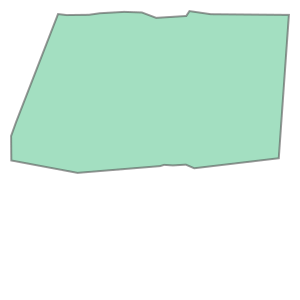

In [5]:
elem = regions.iloc[1][1]
print(elem)
elem

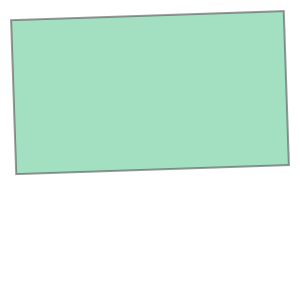

In [6]:
rectangle = elem.minimum_rotated_rectangle
rectangle = gp.GeoSeries(rectangle)
rectangle.iloc[0]

In [9]:
import shapely
num_points = 10
dim = 100_000
A = rectangle.sample_points(1)
print(A)
B = A.translate(xoff=dim, yoff=0.0, zoff=0.0)
C = A.translate(xoff=dim, yoff=dim, zoff=0.0)
D = A.translate(xoff=0.0, yoff=dim, zoff=0.0)

poly = shapely.Polygon((A[0], B[0], C[0], D[0]))
type(poly)

0    POINT (-5613628.541 10451550.095)
Name: sampled_points, dtype: geometry


shapely.geometry.polygon.Polygon

41644


(3, 512, 512)

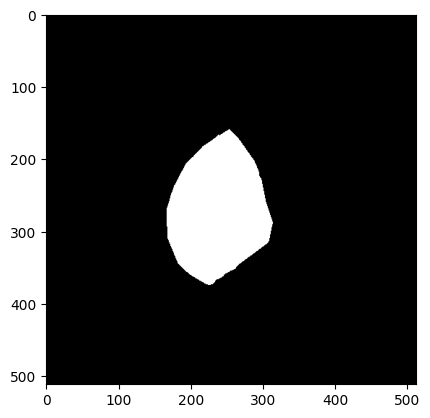

In [24]:
img_region_path = Path("/data1/malto/sigspatial/ds_train_label/")
print(len(os.listdir(img_region_path)))
for i in range(2100, len(os.listdir(img_region_path))):
    img = os.listdir(img_region_path)[i]
    img_region = rasterio.open(img_region_path / img)
    img_array = img_region.read()
    #if img_array.max() != 0:
    #    break
    if img_array.shape != (3, 225, 225):
        break
plt.imshow(np.transpose(img_array, ((1, 2, 0))))
img_array.shape

In [12]:
ToTensor()(np.transpose(img_array, ((1, 2, 0))))

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

15302


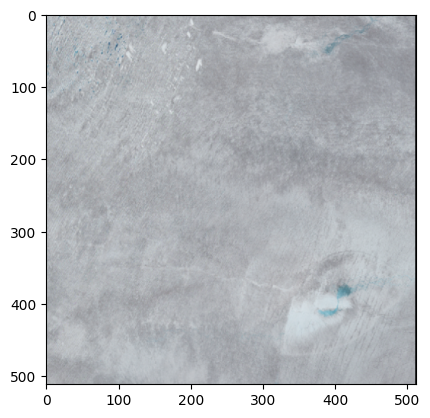

In [11]:
img_region_path = BASE_DIR / "test_image"
print(len(os.listdir(img_region_path)))
img = os.listdir(img_region_path)[2450]
img_region = rasterio.open(img_region_path / img)
img_array = img_region.read()
plt.imshow(np.transpose(img_array, ((1, 2, 0))))

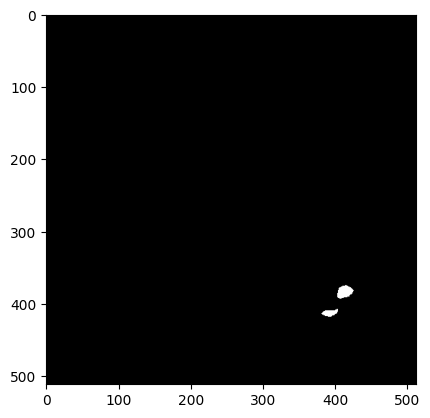

In [12]:
img_region_path = BASE_DIR / "predictions"
img_region = rasterio.open(img_region_path / img)
img_array = img_region.read()
plt.imshow(np.transpose(img_array, ((1, 2, 0))))

In [11]:
img_array.shape

(3, 22641, 28235)

In [12]:
rect = get_external_rectangle(regions=regions, num_region=1)

/home/fborra/sigspatialcup2023/utils.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return gp.GeoSeries(regions.iloc[num_region][1].minimum_rotated_rectangle)


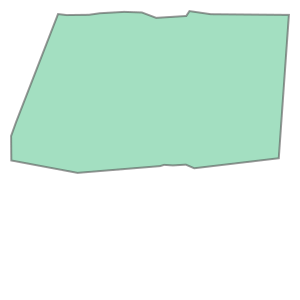

In [21]:
regions.iloc[1]['geometry']

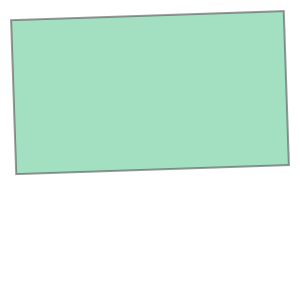

In [16]:
rect[0]

In [9]:
from utils import get_square

while True:
    poly = get_square(rectangle)
    out_image, out_transform = rasterio.mask.mask(img_region, [poly], crop=True)
    if not is_valid(out_image):
        continue
    else:
        break

0 723
3 736


In [24]:
lakes_regions[(lakes_regions['image'] == "Greenland26X_22W_Sentinel2_2019-06-03_05.tif") & (lakes_regions['region_num'] == 2)]

,image,region_num,geometry
0,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,2,"POLYGON ((-5557392.360 10529124.209, -5557430...."
1,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,2,"POLYGON ((-5515504.868 10233656.876, -5515543...."
2,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,2,"POLYGON ((-5515199.120 10446801.530, -5515160...."
3,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,2,"POLYGON ((-5502090.170 10342694.297, -5502090...."
4,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,2,"POLYGON ((-5500714.304 10485784.414, -5500714...."
...,...,...,...
383,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,2,"POLYGON ((-5451374.202 10248256.349, -5451297...."
384,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,2,"POLYGON ((-5460508.427 10242408.916, -5460470...."
385,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,2,"POLYGON ((-5462304.697 10241606.327, -5462304...."
386,Greenland26X_22W_Sentinel2_2019-06-03_05.tif,2,"POLYGON ((-5458253.534 10239427.872, -5458253...."


In [34]:
lake_geom = lakes_regions[lakes_regions['region_num'] == 2]['geometry']

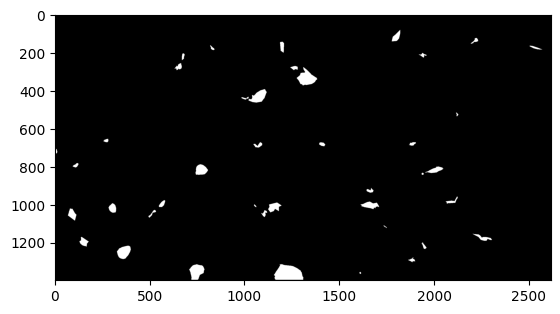

In [37]:

img_trial = rasterio.open(img_trial_path)

out_image, _ = rasterio.mask.mask(img_trial, lake_geom)
out_image[out_image != 0] = 255

plt.imshow(np.transpose(out_image, ((1, 2, 0))))

In [28]:
img_region

<open DatasetReader name='/data1/malto/train/train_img1.tif' mode='r'>

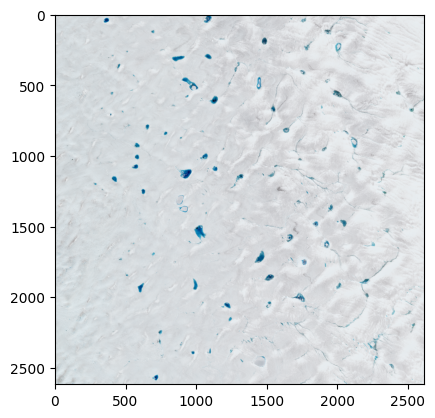

In [14]:
import matplotlib.pyplot as plt

plt.imshow(np.transpose(out_image, ((1, 2, 0))))

In [ ]:
lake

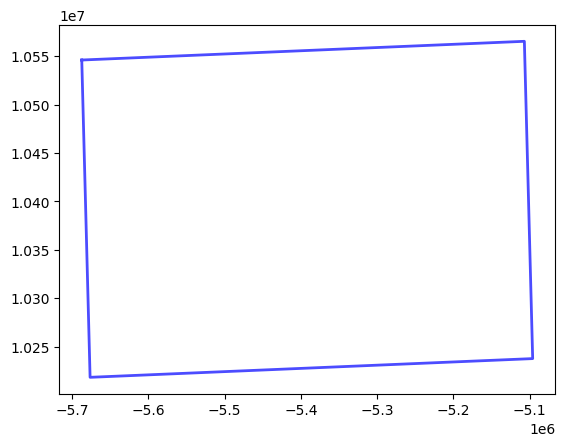

In [118]:
import matplotlib.pyplot as plt

# extract x-y coordinates
x, y = rectangle.iloc[0].exterior.xy
# xx, yy = poly.exterior.xy


# Plot the polygon
plt.plot(x, y, color='blue', alpha=0.7, linewidth=2, label='Polygon')
# plt.plot(x, y, color='blue', alpha=0.7, linewidth=2, label='Polygon')
# # plot original polygon 
# plt.plot(xx, yy, color='green', alpha=0.7, linewidth=2, label='Square')
# # Plot the point 
# plt.plot(A.x, A.y, 'ro', label='Point')

In [119]:
img_region_path = "/data1/malto/train/train_img1.tif"
img_region = rasterio.open(img_region_path)



In [120]:
img_region

<open DatasetReader name='/data1/malto/train/train_img1.tif' mode='r'>

In [121]:
out_image, out_transform = rasterio.mask.mask(img_region, [poly], crop=True)
out_meta = img_region.meta

# Update the metadata for the output file
out_meta.update({"driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform})

# Save the clipped image to a new .tif file
output_filename = f'trial_image.tif'
with rasterio.open(output_filename, "w", **out_meta) as dest:
    dest.write(out_image)

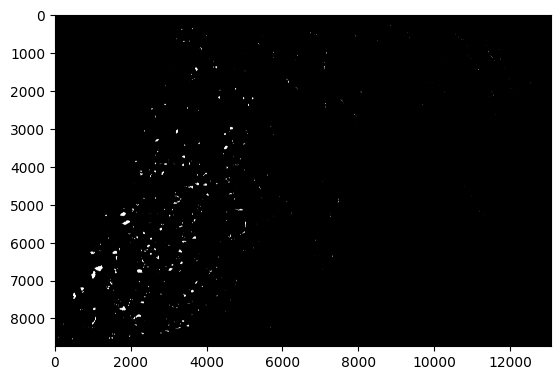

In [41]:
from utils import plot_image

plot_image("/data1/malto/sigspatial/big_predictions/1/Greenland26X_22W_Sentinel2_2019-06-03_05.tif")


In [42]:
plot_image("/data1/malto/sigspatial/Greenland26X_22W_Sentinel2_2019-06-03_05.tif")

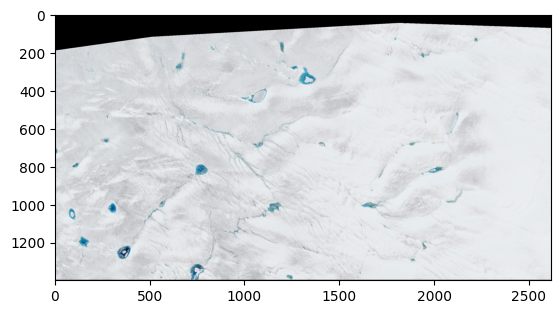

In [123]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(out_image, ((1, 2, 0))))

In [59]:
regions.iloc[1][1]
type(regions.iloc[1][1])

shapely.geometry.polygon.Polygon

In [21]:
import pathlib
import utils

def select_image_with_lake():
    
    BASE_DIR = utils.BASE_DIR
    train_images = sorted([name for name in os.listdir(BASE_DIR / "ds_train_images") if name.split(".")[-1] == "tif"])
    i = 0
    for im in train_images:
        if rasterio.open(BASE_DIR / "ds_train_label" / im).read().max() == 0:
            continue
        elif i < 3 :
            i += 1
        else: 
            break

    return im


In [22]:
from utils import generate_label
import cv2 as cv
import numpy as np
from shapely.geometry import Polygon

BASE_DIR = utils.BASE_DIR

example_label_path =  select_image_with_lake()
print(example_label_path)
example_label_path = BASE_DIR / "ds_train_images" / example_label_path
lbl_trial = rasterio.open(example_label_path)
lbl_trial_array = lbl_trial.read()
# non_zeros_present = np.any(lbl_trial_array != 0)
# non_zeros_present
grayscale_image = cv.cvtColor(lbl_trial_array.transpose(1, 2, 0), cv.COLOR_BGR2GRAY)
# Each contour is stored as a vector of points
contours, _ = cv.findContours(grayscale_image.astype(np.uint8), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# Construct the polygons 
polygons = [Polygon(c.reshape(-1, 2)) for c in contours if len(c) > 2]


Greenland26X_22W_Sentinel2_2019-06-03_05.tif_region_2.tif_-5433792.472835924_10330216.244954892.tif


In [10]:
for mask_path in os.listdir(BASE_DIR / "big_predictions" / "1"):
    print(mask_path)


Greenland26X_22W_Sentinel2_2019-07-31_25.tif
Greenland26X_22W_Sentinel2_2019-06-03_05.tif


In [25]:
from shapely.geometry import Polygon

grayscale_image = cv2.cvtColor(img_array.transpose(1, 2, 0), cv2.COLOR_BGR2GRAY)
# Each contour is stored as a vector of points
contours, _ = cv2.findContours(grayscale_image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# print(contours)
# Construct the polygons 
polygons = [Polygon(c.reshape(-1, 2)) for c in contours if len(c) > 2]
print(type(polygons[0]))
print(type(polygons))
print(type(img_array))



<class 'shapely.geometry.polygon.Polygon'>
<class 'list'>
<class 'numpy.ndarray'>


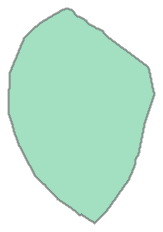

In [27]:
polygons[0]

In [40]:
column_names = ["image", "region_num", "geometry"]
gdf = gp.GeoDataFrame(columns = column_names)


# Create a new row to append
new_row = {
    'image': 'random.tif',
    'region_num': 2,
    'geometry': polygons[0]
}

# Append the new row to the GeoDataFrame
gdf.loc[len(gdf)] = new_row

gdf.set_geometry('geometry', drop=False, inplace=True, crs="EPSG:4326")
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

AttributeError: The CRS attribute of a GeoDataFrame without an active geometry column is not defined. Use GeoDataFrame.set_geometry to set the active geometry column.

In [30]:

# Extract the point values that define the perimeter of the polygon
xx, yy = polygons[0].exterior.coords.xy
print(xx)
print(yy)

array('d', [253.0, 251.0, 250.0, 249.0, 248.0, 246.0, 245.0, 243.0, 242.0, 240.0, 239.0, 238.0, 233.0, 232.0, 229.0, 228.0, 226.0, 225.0, 223.0, 222.0, 220.0, 219.0, 217.0, 216.0, 216.0, 204.0, 204.0, 203.0, 202.0, 193.0, 193.0, 192.0, 192.0, 191.0, 191.0, 190.0, 190.0, 189.0, 189.0, 187.0, 187.0, 186.0, 186.0, 185.0, 185.0, 184.0, 184.0, 183.0, 183.0, 182.0, 182.0, 181.0, 181.0, 180.0, 180.0, 179.0, 179.0, 177.0, 177.0, 176.0, 176.0, 175.0, 175.0, 174.0, 174.0, 173.0, 173.0, 172.0, 172.0, 171.0, 171.0, 170.0, 170.0, 169.0, 169.0, 168.0, 168.0, 167.0, 167.0, 168.0, 168.0, 169.0, 169.0, 170.0, 170.0, 171.0, 171.0, 172.0, 172.0, 173.0, 173.0, 174.0, 174.0, 175.0, 175.0, 176.0, 176.0, 177.0, 177.0, 178.0, 178.0, 179.0, 179.0, 180.0, 180.0, 181.0, 181.0, 182.0, 182.0, 194.0, 195.0, 199.0, 200.0, 202.0, 203.0, 204.0, 205.0, 207.0, 208.0, 209.0, 210.0, 212.0, 213.0, 214.0, 215.0, 216.0, 217.0, 219.0, 220.0, 221.0, 223.0, 224.0, 227.0, 228.0, 230.0, 233.0, 233.0, 236.0, 238.0, 239.0, 240.0, 2

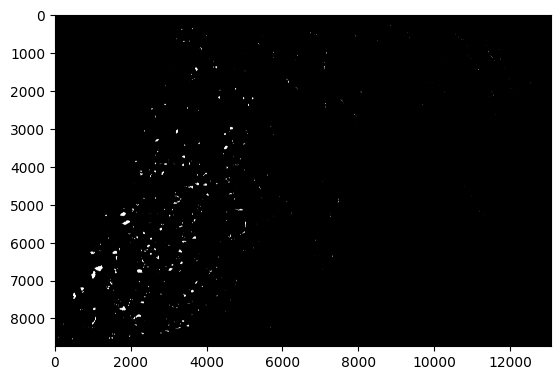

In [5]:

plot_image("/data1/malto/sigspatial/big_predictions/1/Greenland26X_22W_Sentinel2_2019-06-03_05.tif")

In [84]:
# Create empty dataFrame
column_names = ["image", "region_num", "geometry"]
# column_names = [str , numpy.int64, shapely.geometry.polygon.Polygon]
gdf = gp.GeoDataFrame(columns = column_names)

# regions = sorted([name for name in os.listdir(BASE_DIR / "big_predictions")])

mask_path = "Greenland26X_22W_Sentinel2_2019-06-03_05.tif"
region = 2
# for region in regions:
#     for mask_path in os.listdir(BASE_DIR / "big_predictions" / region):
whole_mask_path = "/data1/malto/sigspatial/big_predictions/1/Greenland26X_22W_Sentinel2_2019-06-03_05.tif"
# whole_mask_path = "/data1/malto/sigspatial/ds_train_label/Greenland26X_22W_Sentinel2_2019-06-03_05.tif_region_2.tif_-5433792.472835924_10330216.244954892.tif"
mask = rasterio.open(whole_mask_path)
mask_array = mask.read()
polygons_list = utils.mask_to_polygons(mask_array)
for polygon in polygons_list:
    new_row = {'image': mask_path,'region_num': region, 'geometry': polygon}
    gdf.loc[len(gdf)] = new_row
# gdf.set_geometry('geometry', drop=False, inplace=True, crs="EPSG:4326")



In [83]:
gdf_mercador = gdf.to_crs(crs = "EPSG:3857")
print(gdf_mercador)
# gdf['Area'] = gdf_mercador.area
# print(gdf['Area'])
# gdf_filt = gdf[gdf['Area']>= 100000]
# gdf_filt
# gdf.area 


                                            image  region_num  \
0    Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
1    Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
2    Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
3    Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
4    Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
..                                            ...         ...   
580  Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
581  Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
582  Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
583  Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   
584  Greenland26X_22W_Sentinel2_2019-06-03_05.tif           2   

                                              geometry  Area  
0    POLYGON ((inf inf, inf inf, inf inf, inf inf, ...   NaN  
1    POLYGON ((inf inf, inf inf, inf inf, inf inf, ...   NaN  
2    POLYGON ((inf inf, inf in

In [19]:
xx, yy = gdf['geometry'][0].exterior.coords.xy
print(xx)
print(yy)

array('d', [448.0, 447.0, 445.0, 443.0, 443.0, 442.0, 442.0, 443.0, 443.0, 444.0, 444.0, 445.0, 446.0, 449.0, 450.0, 452.0, 453.0, 454.0, 454.0, 455.0, 472.0, 474.0, 475.0, 476.0, 478.0, 479.0, 479.0, 478.0, 478.0, 477.0, 477.0, 476.0, 476.0, 473.0, 473.0, 472.0, 472.0, 465.0, 464.0, 463.0, 463.0, 462.0, 460.0, 459.0, 457.0, 456.0, 455.0, 453.0, 452.0, 448.0])
array('d', [8529.0, 8530.0, 8530.0, 8532.0, 8533.0, 8534.0, 8535.0, 8536.0, 8537.0, 8538.0, 8539.0, 8540.0, 8540.0, 8543.0, 8543.0, 8545.0, 8545.0, 8546.0, 8547.0, 8547.0, 8564.0, 8564.0, 8565.0, 8564.0, 8564.0, 8563.0, 8557.0, 8556.0, 8555.0, 8554.0, 8553.0, 8552.0, 8550.0, 8547.0, 8546.0, 8545.0, 8544.0, 8537.0, 8537.0, 8536.0, 8535.0, 8535.0, 8533.0, 8533.0, 8531.0, 8531.0, 8530.0, 8530.0, 8529.0, 8529.0])


In [29]:
xx, yy = gdf['geometry'][0].exterior.coords.xy
print(xx)
print(yy)

array('d', [175.0, 174.0, 173.0, 172.0, 173.0, 174.0, 177.0, 178.0, 182.0, 183.0, 186.0, 186.0, 187.0, 187.0, 188.0, 188.0, 185.0, 184.0, 183.0, 175.0])
array('d', [173.0, 174.0, 174.0, 175.0, 176.0, 176.0, 179.0, 179.0, 183.0, 183.0, 186.0, 185.0, 184.0, 181.0, 180.0, 177.0, 174.0, 174.0, 173.0, 173.0])


1. Obtain contours
2. Obtain polygons from contours
3. post-processing:
    a. eliminate polygons that are contained inside other polygons using is_contain function
    ...